In [10]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [11]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [12]:
from _moving_average_convergence_divergence import MovingAverageConvergenceDivergence

In [13]:
#data=pd.read_csv("MASI_2.csv",parse_dates=True, index_col=0)

In [58]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)

In [29]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


In [30]:
data["Volume"]=data.Close

In [31]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,12420.15,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,12509.58,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,12463.08,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,12537.75,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,12479.42,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,12640.22,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,12721.38,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,12751.45,MAD


In [59]:
df=data["Close"]
high=data["High"]
low=data["Low"]



## Fonction

In [33]:
premier=0 

In [34]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [35]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

## **TEST macd**

In [42]:
macd=MovingAverageConvergenceDivergence(data)

In [37]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [38]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

def obj_macd1(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
		signal=pd.DataFrame(index=df.index)
		MACD=macd.calculateTi(wl,ws)["macd"]
			#MACD=at.macd(df,ws,wl)["MACD"]
		signal["compa"]=np.nan
		signal["compa"][wl:]=np.where(MACD[wl:]>0 ,1 ,0)
		signal["signal"]=adjustsignal(signal["compa"].diff())
		cours=df*(1+taux*signal["signal"])
		pmval=pmv(cours,signal["signal"])
		return pmval.max(),

In [39]:
data

,open,high,low,close,volume,currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,12420.15,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,12509.58,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,12463.08,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,12537.75,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,12479.42,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,12640.22,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,12721.38,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,12751.45,MAD


In [43]:
macd._calculateTi(wl=12,ws=26)[["macd","signal_line"]]

,macd,signal_line
Date,,
2018-01-02,NaN,NaN
2018-01-03,NaN,NaN
2018-01-04,NaN,NaN
2018-01-05,NaN,NaN
2018-01-08,NaN,NaN
...,...,...
2022-03-28,183.6008,200.0047
2022-03-29,170.1133,194.0264
2022-03-30,155.2088,186.2629


In [47]:
macd.getTiSignal()

('hold', 0)

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

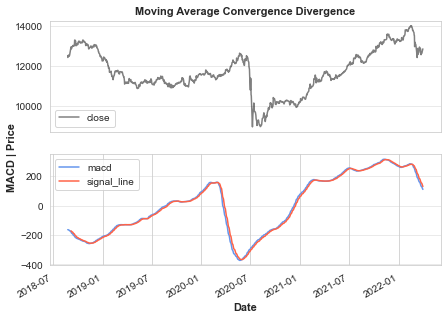

In [48]:
macd.getTiGraph()

In [52]:
data=df

In [53]:
df=pd.DataFrame(df)

In [54]:
df

,Close
Date,
2018-01-02,12420.15
2018-01-03,12509.58
2018-01-04,12463.08
2018-01-05,12537.75
2018-01-08,12479.42
...,...
2020-05-26,9847.80
2020-05-27,9935.25
2020-05-28,9844.88


In [60]:
def obj_macd2(n):
    ws=int(n[0])
    wl=int(n[1])
    if ws > wl :
        ws,wl=wl,ws
    #MACD=at.macd(df,ws,wl)[["MACD","MACDsignal"]]
    MACD=macd._calculateTi(wl,ws)[["macd","signal_line"]]
    #MACD=MACD.dropna()
    signal=pd.DataFrame(columns=["compa"],index=df.index)
    #signal["compa"]=np.nan
    signal["compa"][wl:]=np.where(MACD["macd"][wl:] > MACD["signal_line"][wl:] ,1 ,0 )
    signal["signal"]=adjustsignal(signal["compa"].diff())
    cours=df*(1+taux*signal["signal"])
    pmval=pmv(cours,signal["signal"])
    return pmval.max(),

wl, ws = 26,12

signal=pd.DataFrame(index=df.index)
MACD=macd._calculateTi(wl,ws)[["macd","signal_line"]]
signal["compa"]=np.nan

    MACD=macd._calculateTi(wl,ws)[["macd","signal_line"]]
    signal=pd.DataFrame(index=MACD.index)
    signal["compa"]=np.nan
    signal["compa"][wl:]=np.where(MACD["macd"][wl:] > MACD["signal_line"][wl:] ,1 ,0 )

In [ ]:
arr = np.where(MACD["macd"][wl:] > MACD["signal_line"][wl:] ,1 ,0 )

In [ ]:
len(arr)

In [ ]:
signal['compa'][wl:]

In [ ]:
signal["compa"][wl:]=np.where(MACD["macd"][wl:] > MACD["signal_line"][wl:] ,1 ,0 )

def obj_macd2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	MACD=at.macd(df,ws,wl)[["MACD","MACDsignal"]]
	signal["compa"][wl:]=np.where(MACD["MACD"][wl:] > MACD["MACDsignal"][wl:] ,1 ,0 )
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg   
0  	40    	2781.72	1664.7
1  	34    	2781.72	2323.97
2  	32    	2781.72	2438.09
3  	34    	2804.61	2619.25
4  	36    	2850.29	2604.16
5  	35    	2850.29	2714.12
6  	38    	2873.47	2752.08
Hall of Fame Individuals = 
[57.102636100047214, 31.063609277041188]
[57.974331572643536, 31]
[57.999978022610954, 31]
[30.06008002985284, 31.993570315735905]
[30.054740213421294, 31]
Best Ever Individual =  [57, 31]


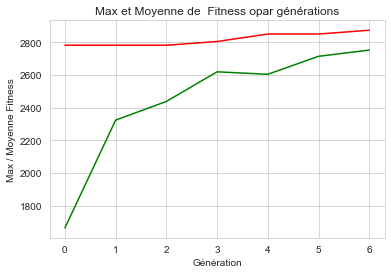

In [61]:
GeneticAlgo(2,obj_macd2,6,10,60)
#58-30
#10-

gen	nevals	max    	avg    
0  	40    	2877.06	1023.61
1  	36    	2877.06	1697.99
2  	35    	2947.66	2395.41
3  	36    	2947.66	2596.97
4  	38    	2947.66	2752.76
5  	36    	2947.66	2894.02
6  	34    	2947.66	2857.92
7  	31    	2947.66	2847.8 
8  	33    	2947.66	2816.99
9  	36    	2947.66	2846.97
10 	40    	2947.66	2872.12
Hall of Fame Individuals = 
[26.00009718389862, 36.956468138432975]
[26.00237093541953, 36.96240250531725]
[26, 36.95513952626992]
[26.01215766770195, 36.956468138432975]
[26, 36.956468138432975]
Best Ever Individual =  [26, 36]


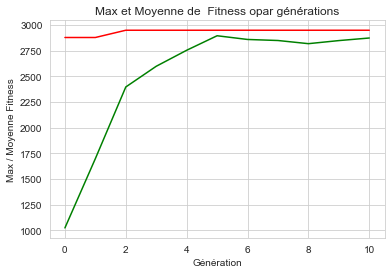

In [62]:
GeneticAlgo(2,obj_macd2,10,12,40)
#39-40
#39-36